# 3D R2 N2

![Image](./additional/3dr2n2.png)

**Paper**: [http://3d-r2n2.stanford.edu/main.pdf](http://3d-r2n2.stanford.edu/main.pdf)

### Encoder

Input: 127x127 RGB Image
Output: 1024 feature vector

### Decoder

Output: 32x32x32

### Training

60,000 iterations, 36 batch size

LeakyReLU with 0.1, Adam, weight initalisation with MSRA and 0.1 for all biases

In [1]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
from torchvision import transforms, utils
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import binvox_rw

In [2]:
data_root = './data/shape_net'
class_id = '02691156'

n_convfilter = [96, 128, 256, 256, 256, 256]
n_fc_filters = [1024]
n_deconvfilter = [128, 128, 128, 64, 32, 2]
n_deconvfilter = [128, 128, 64, 32, 2, 2]

in_channels = 3
output_dim = 32
z_dim = 1024
slope = 0.1

batch_size = 16
num_epochs = 1

n_gpu = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() and n_gpu>0 else "cpu")
print("Running on {} GPUs.".format(n_gpu) if n_gpu>0 else "Running on CPU.")

Running on 1 GPUs.


In [3]:
class ShapeNetDataset(torch.utils.data.Dataset):
    def __init__(self, data_root, transforms=None):
        self.transforms = transforms
        self.path_voxel = os.path.join(data_root, 'ShapeNetVox32', class_id)
        self.path_img = os.path.join(data_root, 'ShapeNetRendering', class_id)
        
        self.voxel_list = []
        self.img_list = []
        
        for dir_id in os.listdir(self.path_img):
            bv = os.path.join(self.path_voxel, dir_id, 'model.binvox')
            self.voxel_list.append(bv)
            rend = os.path.join(self.path_img, dir_id, 'rendering', '00.png') # Just take the first image
            self.img_list.append(rend)
                  
    def __len__(self):
        return len(self.voxel_list)
    
    def __getitem__(self, idx):
        with open(self.voxel_list[idx], 'rb') as f:
            bv_arr = binvox_rw.read_as_3d_array(f).data.astype(float)  
        bv_arr = torch.Tensor(bv_arr)
        
        rend_img = Image.open(self.img_list[idx])
        rend_img = rend_img.convert("RGB")
        if self.transforms is not None:
            rend_img = self.transforms(rend_img)
        
        return (rend_img, bv_arr)

In [4]:
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [5]:
dataset = ShapeNetDataset(data_root, transforms=data_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
img, vox = next(iter(dataloader))

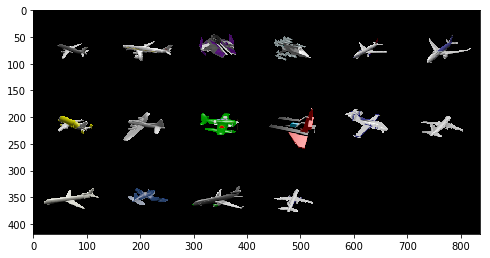

In [7]:
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(utils.make_grid(img.to(device), nrow=6, padding=2, normalize=True),(1,2,0)))

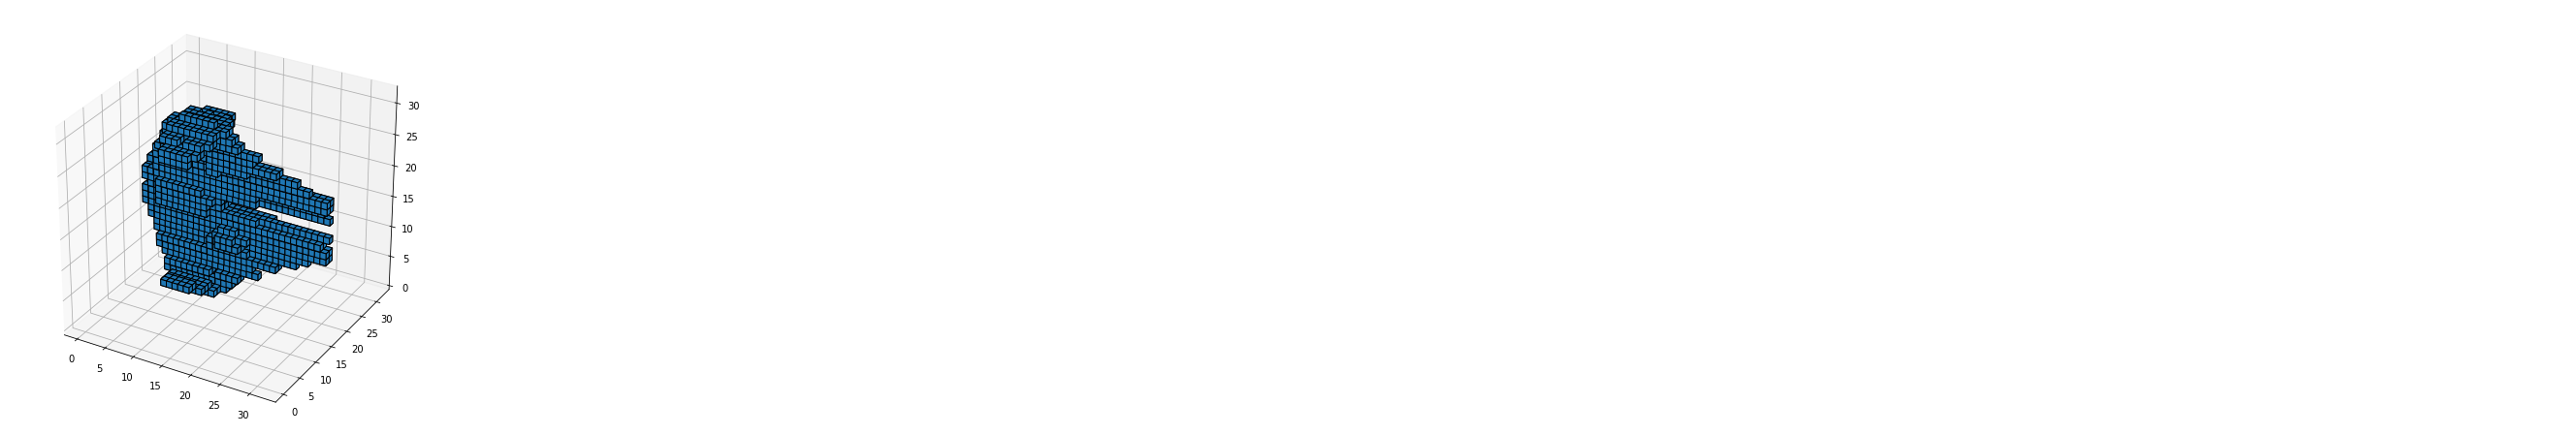

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection="3d")
ax.voxels(np.transpose(vox[2].numpy(), (0,1,2)), edgecolor='k')
plt.show()

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.res_block1 = nn.Sequential( # In: 3x127x127
            nn.Conv2d(in_channels=in_channels, out_channels=n_convfilter[0], kernel_size=7, stride=1, padding=3),
            nn.BatchNorm2d(n_convfilter[0]),
            nn.LeakyReLU(negative_slope=slope),
            nn.Conv2d(n_convfilter[0], n_convfilter[0], 3, 1, 1),
            nn.BatchNorm2d(n_convfilter[0]))
        self.t1 = nn.Conv2d(in_channels=in_channels, out_channels=n_convfilter[0], kernel_size=1, stride=1, padding=0)
        self.pool = nn.Sequential(nn.LeakyReLU(negative_slope=slope),nn.MaxPool2d(2, padding=1)) # 64x64
        self.pool2 = nn.Sequential(nn.LeakyReLU(negative_slope=slope),nn.MaxPool2d(2, padding=0)) # 64x64
        self.res_block2 = nn.Sequential( # In 64x64
            nn.Conv2d(n_convfilter[0], n_convfilter[1], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_convfilter[1]),
            nn.LeakyReLU(slope),
            nn.Conv2d(n_convfilter[1], n_convfilter[1], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_convfilter[1]))
        self.t2 = nn.Conv2d(n_convfilter[0], n_convfilter[1], 1, 1, 0)
        self.res_block3 = nn.Sequential( # In 32^2
            nn.Conv2d(n_convfilter[1], n_convfilter[2], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_convfilter[2]),
            nn.LeakyReLU(slope),
            nn.Conv2d(n_convfilter[2], n_convfilter[2], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_convfilter[2]))
        self.t3 = nn.Conv2d(n_convfilter[1], n_convfilter[2], 1, 1, 0) 
        self.res_block4 = nn.Sequential( # In 16^2
            nn.Conv2d(n_convfilter[2], n_convfilter[3], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_convfilter[2]),
            nn.LeakyReLU(slope),
            nn.Conv2d(n_convfilter[3], n_convfilter[3], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_convfilter[2]))        
        self.res_block5 = nn.Sequential( # In 8^2
            nn.Conv2d(n_convfilter[3], n_convfilter[4], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_convfilter[4]),
            nn.LeakyReLU(slope),
            nn.Conv2d(n_convfilter[4], n_convfilter[4], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_convfilter[4]))
        self.t5 = nn.Conv2d(n_convfilter[3], n_convfilter[4], 1, 1, 0)
        self.res_block6 = nn.Sequential( # In 4^2
            nn.Conv2d(n_convfilter[4], n_convfilter[5], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_convfilter[5]),
            nn.LeakyReLU(slope),
            nn.Conv2d(n_convfilter[5], n_convfilter[5], kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(n_convfilter[5]))
        self.t6 = nn.Conv2d(n_convfilter[4], n_convfilter[5], 1, 1, 0)
        self.fc = nn.Sequential(nn.Linear(2*2*n_convfilter[5], z_dim), nn.LeakyReLU(slope))
        
    def forward(self, x):
        r = x
        x = self.res_block1(x)
        r = self.t1(r)
        x = self.pool(x+r)
        r = x
        
        x = self.res_block2(x)
        r = self.t2(r)
        x = self.pool2(x+r)
        r = x

        x = self.res_block3(x)
        r = self.t3(r)
        x = self.pool2(x+r)

        # Exception case: block 4 no residual connection
        x = self.res_block4(x)
        x = self.pool2(x)

        r = x
        x = self.res_block5(x)
        r = self.t5(r)
        x = self.pool2(x+r)

        r = x
        x = self.res_block6(x)
        r = self.t6(r)
        x = self.pool2(x+r)
        
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [10]:
encoder = Encoder().to(device)

In [11]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.factor = scale_factor
        
    def forward(self, x):
        x = self.interp(x, scale_factor=self.factor)
        return x

In [12]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        #self.unpool = nn.MaxUnpool3d(2) # Upsamples by 2
        #self.unpool_act = nn.Sequential(nn.LeakyReLU(slope), nn.MaxUnpool3d(2)) # Activates and Upsamples by 2
        
        self.unpool = Interpolate(scale_factor=2)
        self.unpool_act = nn.Sequential(nn.LeakyReLU(slope), Interpolate(scale_factor=2))
        
        in_c = 128
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose3d(in_c, n_deconvfilter[0], 3, 1, 1),
            nn.BatchNorm3d(n_deconvfilter[0]),
            nn.LeakyReLU(slope),
            nn.ConvTranspose3d(n_deconvfilter[0], n_deconvfilter[0], 3, 1, 1),
            nn.BatchNorm3d(n_deconvfilter[0]))
        self.t1 = nn.Conv3d(in_c, n_deconvfilter[0], 1, 1, 0)
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose3d(n_deconvfilter[0], n_deconvfilter[1], 3, 1, 1),
            nn.BatchNorm3d(n_deconvfilter[1]),
            nn.LeakyReLU(slope),
            nn.ConvTranspose3d(n_deconvfilter[1], n_deconvfilter[1], 3, 1, 1),
            nn.BatchNorm3d(n_deconvfilter[1]))
        self.t2 = nn.Conv3d(n_deconvfilter[0], n_deconvfilter[1], 1, 1, 0)
        self.deconv3 = nn.Sequential(
            nn.ConvTranspose3d(n_deconvfilter[1], n_deconvfilter[2], 3, 1, 1),
            nn.BatchNorm3d(n_deconvfilter[2]),
            nn.LeakyReLU(slope),
            nn.ConvTranspose3d(n_deconvfilter[2], n_deconvfilter[2], 3, 1, 1),
            nn.BatchNorm3d(n_deconvfilter[2]))
        self.t3 = nn.Conv3d(n_deconvfilter[1], n_deconvfilter[2], 1, 1, 0)
        self.deconv4 = nn.Sequential(
            nn.ConvTranspose3d(n_deconvfilter[2], n_deconvfilter[3], 3, 1, 1),
            nn.BatchNorm3d(n_deconvfilter[3]),
            nn.LeakyReLU(slope),
            nn.ConvTranspose3d(n_deconvfilter[3], n_deconvfilter[4], 3, 1, 1),
            nn.BatchNorm3d(n_deconvfilter[4]),
            nn.ConvTranspose3d(n_deconvfilter[4], n_deconvfilter[5], 3, 1, 1),
            nn.BatchNorm3d(n_deconvfilter[5]))
        self.t4 = nn.Conv3d(n_deconvfilter[2], n_deconvfilter[5], 1, 1, 0)
        self.act = nn.LeakyReLU(slope)
        self.deconv5 = nn.Sequential(nn.ConvTranspose3d(n_deconvfilter[5], 1, 3, 1, 1), nn.Sigmoid()) 
        
        
    def forward(self, x):
        d = int(output_dim/(2**4))
        x = x.view(x.shape[0], -1, d, d, d)
        
        x = self.unpool(x)
        r = x
        x = self.deconv1(x)
        r = self.t1(r)
        x = self.unpool_act(x+r)
        r = x
        x = self.deconv2(x)
        r = self.t2(r)
        x = self.unpool_act(x+r)
        r = x
        x = self.deconv3(x)
        r = self.t3(r)
        x = self.unpool_act(x+r)
        r = x
        x = self.deconv4(x)
        r = self.t4(r)
        x = self.act(x+r)
        x = self.deconv5(x)
        x = x.view(-1, 32, 32, 32)
        return x

In [13]:
decoder = Decoder().to(device)

In [14]:
criterion = nn.BCELoss()
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

In [15]:
num_batches_per_epoch = len(dataloader)

In [16]:
for epoch in range(num_epochs):
    since = time.time()
    print("#"*20, "Epoch {}/{}".format(epoch+1, num_epochs), "#"*20)
    for i, data in enumerate(dataloader):
        since_b = time.time()
        batch_img = data[0]
        batch_img = data[0].to(device)
        batch_vox = data[1].to(device)
        
        z = encoder(batch_img)
        outputs = decoder(z)
        outputs = outputs.view(outputs.shape[0], -1)
        batch_vox = batch_vox.view(batch_vox.shape[0], -1)
              
        encoder.zero_grad()
        decoder.zero_grad()
        loss = criterion(outputs, batch_vox)
        loss.backward()
        optimizer.step()
        b_time = time.time() - since_b
        if i%50 == 0:
            print('[{}/{}]\tLoss: {}\nTime: {}'.format(i+1, num_batches_per_epoch, loss, b_time))
    
    t = time.time() - since
    print('Epoch Time: {}'.format(t))

#################### Epoch 1/1 ####################
[1/253]	Loss: 0.6910926699638367
Time: 0.2299184799194336
[51/253]	Loss: 0.0462365448474884
Time: 0.33890557289123535
[101/253]	Loss: 0.045425672084093094
Time: 0.3081080913543701
[151/253]	Loss: 0.036390408873558044
Time: 0.3744015693664551
[201/253]	Loss: 0.040792133659124374
Time: 0.32713890075683594
[251/253]	Loss: 0.05349304899573326
Time: 0.32575249671936035
Epoch Time: 81.52357006072998


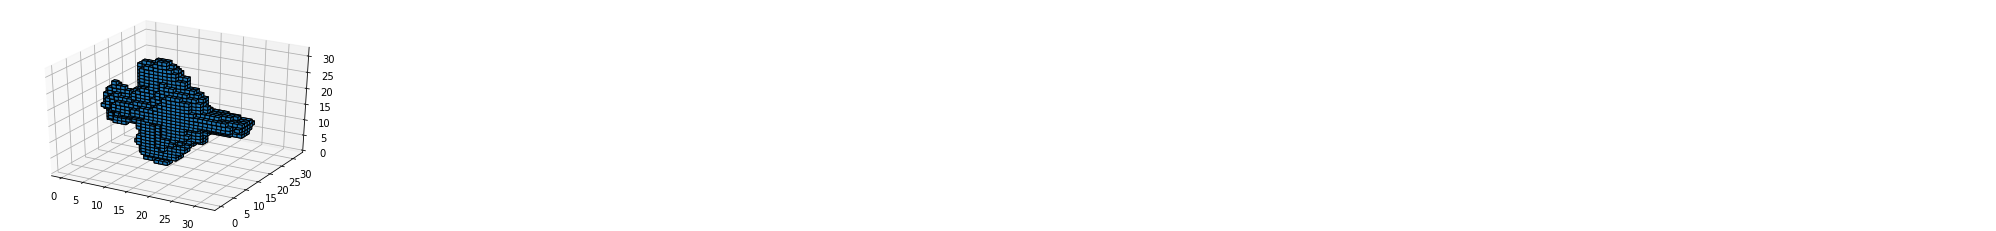

In [29]:
batch_img, batch_vox = next(iter(dataloader))
batch_img = batch_img.to(device)
z = encoder(batch_img)
ex_vox = decoder(z).detach().cpu().numpy()
bin_img = np.zeros_like(ex_vox[0])
bin_img[ex_vox[0] > 0.1] = 1
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.voxels(np.transpose(bin_img, (0,1,2)), edgecolor='k')
plt.show()